In [1]:
from functools import partial
from itertools import chain
from itertools import product

import pandas as pd
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (16, 7)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['PT Sans']

matplotlib.style.use('fivethirtyeight')

## Прочитати дані

In [3]:
faostat_data = pd.read_csv('./data/FAOSTAT_data_agg.csv')
ers_data = pd.read_csv('./data/ers_2013.csv')
who_data = pd.read_csv('./data/WHO_BMI.csv', header=[1, 3])

In [4]:
def clean_who_header(who_df):
    who_df.columns = who_df.columns.swaplevel()
    who_df.index =  list(who_df['Country', 'Unnamed: 0_level_0'])
    who_df.drop('Country', axis=1, inplace=True)
    who_df.columns = who_df.columns.swaplevel()
    return (who_df
            [~(who_df == 'No data').any(axis=1)]  ## this is ok
            .apply(lambda x: x.apply(lambda y: float(y.split(' [')[0]))))

In [5]:
who_data = clean_who_header(who_data)

/home/zlira/.virtualenvs/food/lib/python3.6/site-packages/ipykernel_launcher.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  after removing the cwd from sys.path.


In [6]:
who_data.head()

2014          2013          2012          2011          2010  \
             Male  Female  Male  Female  Male  Female  Male  Female  Male   
Afghanistan  21.6    23.7  21.5    23.5  21.4    23.4  21.4    23.3  21.3   
Albania      26.5    25.7  26.5    25.7  26.4    25.7  26.3    25.6  26.2   
Algeria      24.3    26.0  24.2    25.9  24.2    25.9  24.1    25.8  24.1   
Andorra      27.7    26.6  27.6    26.6  27.6    26.6  27.6    26.7  27.5   
Angola       22.8    24.1  22.7    24.0  22.6    23.9  22.5    23.8  22.4   

                      ...    1979          1978          1977          1976  \
             Female   ...    Male  Female  Male  Female  Male  Female  Male   
Afghanistan    23.1   ...    19.7    19.9  19.7    19.8  19.6    19.6  19.5   
Albania        25.6   ...    24.0    24.3  24.0    24.3  23.9    24.2  23.8   
Algeria        25.8   ...    21.8    23.6  21.7    23.6  21.6    23.5  21.5   
Andorra        26.7   ...    25.5    26.4  25.5    26.4  25.4    26.3  25.3   
Angola         23.6   ...    20.2    20.0  20.2    19.9  20.1    19.8  20.0   

                     1975          
             Female  Male  Female  
Afghanistan    19.5  19.5    19.4  
Albania        24.2  23.7    24.1  
Algeria        23.4  21.4    23.3  
Andorra        26.3  25.2    26.2  
Angola         19.7  19.9    19.6  

[5 rows x 80 columns]

In [7]:
faostat_data.head()

,Domain Code,Domain,Country Code,Country,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,FBS,Food Balance Sheets,2,Afghanistan,664,Food supply (kcal/capita/day),2901,Grand Total,2013,2013,kcal/capita/day,2090.00,Fc,Calculated data
1,FBS,Food Balance Sheets,2,Afghanistan,674,Protein supply quantity (g/capita/day),2901,Grand Total,2013,2013,g/capita/day,58.25,Fc,Calculated data
2,FBS,Food Balance Sheets,2,Afghanistan,684,Fat supply quantity (g/capita/day),2901,Grand Total,2013,2013,g/capita/day,33.52,Fc,Calculated data
3,FBS,Food Balance Sheets,2,Afghanistan,664,Food supply (kcal/capita/day),2903,Vegetal Products,2013,2013,kcal/capita/day,1873.00,Fc,Calculated data
4,FBS,Food Balance Sheets,2,Afghanistan,674,Protein supply quantity (g/capita/day),2903,Vegetal Products,2013,2013,g/capita/day,46.03,Fc,Calculated data


In [8]:
ers_data.columns = ['Country', 'TotalExp', 'FoodExp']
ers_data.set_index('Country', inplace=True)
ers_data.head()

,TotalExp,FoodExp
Country,,
USA,35160.6,2347.2
Singapore,21104.1,1424.3
Switzerland,45386.5,4072.4
United Kingdom,26019.0,2352.9
Canada,27993.4,2601.3


## Уніфікувати назви країн

У різних наборах даних одні й ті ж країни мають різні назви, тому їх треба звести докупи. Оскільки я використовую лише 86 країн з вибірки 86, то займусь тільки ними.

In [9]:
faostat_countries = set(faostat_data.Country)
who_countries = set(who_data.index)
ers_countries = set(ers_data.index)

In [10]:
print(len(faostat_countries))
print(len(who_countries))
print(len(ers_countries))

175
191
86


In [11]:
matching_countries = faostat_countries.intersection(ers_countries).intersection(who_countries)

Країни, яких намає у FAOSTAT: Bahrain, Qatar, Singapore

Країни, яких немає у WHO: Hon Kong, Taiwan

In [12]:
countries_map = {
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Bosnia-Herzegovina': 'Bosnia and Herzegovina',
    'Czechia': 'Czech Republic',
    'China, Hong Kong SAR': 'Hong Kong, China',
    'Iran (Islamic Republic of)': 'Iran',
    'The former Yugoslav Republic of Macedonia': 'Macedonia',
    'Russian Federation': 'Russia',
    'Republic of Korea': 'South Korea',
    'China, Taiwan Province of': 'Taiwan',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'United States of America': 'United States',
    'USA': 'United States',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Veitnam': 'Viet Nam',
}

In [13]:
who_data.index = who_data.index.to_series().replace(countries_map).values

In [14]:
ers_data.index = ers_data.index.to_series().replace(countries_map).values

In [15]:
faostat_data.Country.replace(countries_map, inplace=True)

## Залежність між загальними витратами і витратами на їжу

In [16]:
# source https://www.ers.usda.gov/data-products/food-expenditures.aspx

# create a column with the rank of the country by total expenditure (from poorest to richest)
ers_data = ers_data.sort_values('TotalExp').assign(ExpRating=lambda x: range(len(x)))

In [17]:
# total and food expenses in three countries for the article
ers_data.loc[['Ukraine', 'Germany', 'United States',], ['FoodExp', 'TotalExp', 'ExpRating']]

,FoodExp,TotalExp,ExpRating
Ukraine,1090.1,2893.7,15
Germany,2477.2,24329.3,74
United States,2347.2,35160.6,82


In [18]:
# function for labeling most interesting countries on different plots
def annotate(country, label, df, x_col, y_col, ax, x_offset=-.6, y_offset=1000):
    country_row = df.loc[country]
    ax.annotate(label, xy=(
        country_row[x_col] + x_offset, country_row[y_col] + y_offset
    ))

In [19]:
annotate_ua = partial(annotate, country='Ukraine', label='Україна')
annotate_de = partial(annotate, country='Germany', label='Німеччина')
annotate_us = partial(annotate, country='United States', label='США')
annotate_ru = partial(annotate, country='Russia', label='Росія')

In [20]:
colors = {
    'red': '#FF2445',
    'yellow': '#FFB100',
    'green': '#56BA00',
    'blue': '#0064A4',
    'purple': '#7500B4',
}

In [21]:
def plot_total_vs_food_exp(df, save_path=None):
    # colors
    color_total = colors['blue']
    color_food = colors['red']

    # area plot
    ax = (df
          [['FoodExp', 'TotalExp']]
          .assign(TotalExp = (df['TotalExp'] - df['FoodExp']))
          .plot.area(alpha=.2, linewidth=0, color=[color_food, color_total],))

    # lines
    df.plot(x='ExpRating', y='TotalExp', ax=ax, color=color_total, linewidth=3)
    df.plot(x='ExpRating', y='FoodExp', ax=ax, color=color_food, linewidth=3)

    # dots and labels for selected countries
    countries_to_plot = ['Ukraine', 'Germany', 'United States']
    selected_df = df.loc[countries_to_plot]

    ax.scatter(x=selected_df.ExpRating, y=selected_df['TotalExp'], s=50, c=color_total)
    ax.scatter(x=selected_df.ExpRating, y=selected_df['FoodExp'], s=50, c=color_food)
    for func in [annotate_ua, annotate_de, annotate_us]:
        func(df=df, ax=ax, x_col='ExpRating', y_col='TotalExp')

    # LABELS AND STYLES
    ax.set_title('Зі збільшенням загальних витрат все менша частка їх припадає на їжу', loc='left')

    ax.set_ylabel('Доларів США на людину на рік (2013)', labelpad=20)

    ax.set_xlabel('Місце країни в рейтингу — від найбідніших до найбагатших', 
                  labelpad=20,
                  horizontalalignment='left')

    ax.get_xaxis().set_ticks([])

    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[:2], ('Загальні витрати', 'Витрати на їжу'), loc=(.82, .85), title='',
        facecolor='white',  
    )
    ax.grid(b=False)

    if save_path:
        plt.savefig(save_path)

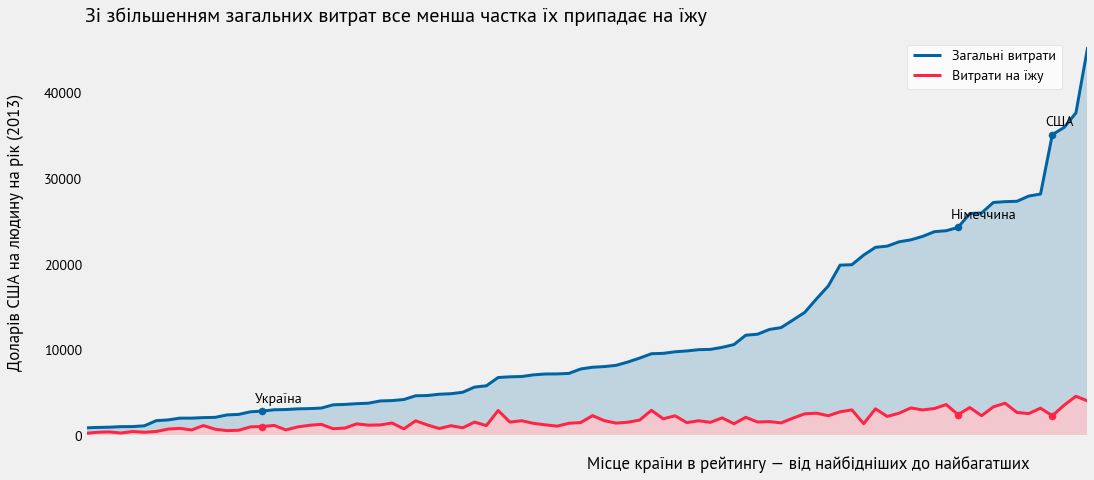

In [22]:
plot_total_vs_food_exp(ers_data)

In [23]:
# Місце України в рейтенгу по витратах їжі (від найбідніших до найбагатших)
list(ers_data.sort_values('FoodExp').index).index('Ukraine')

21

## Забезпечення калоріями

In [24]:
TOTAL_KCAL_NAME = 'Food supply (kcal/capita/day)'
PROTEIN_ELEMENT_NAME = 'Protein supply quantity (g/capita/day)'
FAT_ELEMENT_NAME = 'Fat supply quantity (g/capita/day)'

# https://en.wikipedia.org/wiki/Food_energy
FAT_ENERGY = 8.8  # kcal/g
PROTEIN_ENERGY = 4   # kcal/g

In [25]:
def select_faostat_value(faostat_data, selection_arr, col_name):
    return (faostat_data[selection_arr]
            [['Country', 'Value']]
            .rename(columns={'Value': col_name})
            .set_index('Country'))

In [26]:
def select_faostat_element_total(faostat_data, element_name, element_col_name):
    selected = ((faostat_data.Element == element_name) & (faostat_data.Item == 'Grand Total'))
    return select_faostat_value(faostat_data, selected, element_col_name)

In [27]:
def select_faostat_item_total(faostat_data, item_name, item_col_name):
    selected = ((faostat_data.Item == item_name) & (faostat_data.Element == TOTAL_KCAL_NAME))
    return select_faostat_value(faostat_data, selected, item_col_name)

In [28]:
def faostat_element_vs_expend_rating(faostat_data, expend_data, faostat_element, element_col_name):
    # select and merge data
    element_data = select_faostat_element_total(faostat_data, faostat_element, element_col_name)
    return pd.merge(
        element_data, expend_data, left_index=True, right_index=True
    )

In [29]:
total_kcal_data = select_faostat_element_total(faostat_data, TOTAL_KCAL_NAME, 'FoodTotal')
protein_data = select_faostat_element_total(faostat_data, PROTEIN_ELEMENT_NAME, 'Protein')
fat_data = select_faostat_element_total(faostat_data, FAT_ELEMENT_NAME, 'Fat')

In [30]:
energy_dist_data = pd.DataFrame({
    'FoodTotal': total_kcal_data.FoodTotal,
    'Protein': protein_data.Protein * PROTEIN_ENERGY,
    'Fat': fat_data.Fat * FAT_ENERGY,
    'ExpRank': ers_data.ExpRating,
    'FoodExp': ers_data.FoodExp,
    'TotalExp': ers_data.TotalExp,
}).dropna()

In [31]:
# Ukrain's rank by total calorie consumption
list(energy_dist_data.sort_values('FoodTotal').index).index('Ukraine')

37

In [32]:
energy_dist_data.loc[['Ukraine', 'Germany', 'United States']]

,ExpRank,Fat,FoodExp,FoodTotal,Protein,TotalExp
Ukraine,15.0,814.968,1090.1,3138.0,354.48,2893.7
Germany,74.0,1248.456,2477.2,3499.0,406.36,24329.3
United States,82.0,1421.552,2347.2,3682.0,438.40,35160.6


In [33]:
# list of countries that spend more on food but eat less than Ukraine
energy_dist_data[
    (energy_dist_data.FoodExp >= energy_dist_data.loc['Ukraine', 'FoodExp']) &
    (energy_dist_data.FoodTotal <= energy_dist_data.loc['Ukraine', 'FoodTotal'])
][['FoodExp', 'FoodTotal']].sort_values('FoodTotal').assign(n=lambda x: range(len(x)))

,FoodExp,FoodTotal,n
Guatemala,1220.5,2419.0,0
Dominican Republic,1185.9,2614.0,1
Venezuela,1554.8,2631.0,2
Peru,1500.9,2700.0,3
Nigeria,1208.2,2700.0,4
Japan,3261.6,2726.0,5
Serbia,1275.4,2728.0,6
Turkmenistan,1233.7,2840.0,7
Costa Rica,1468.9,2848.0,8
Malaysia,1200.8,2916.0,9


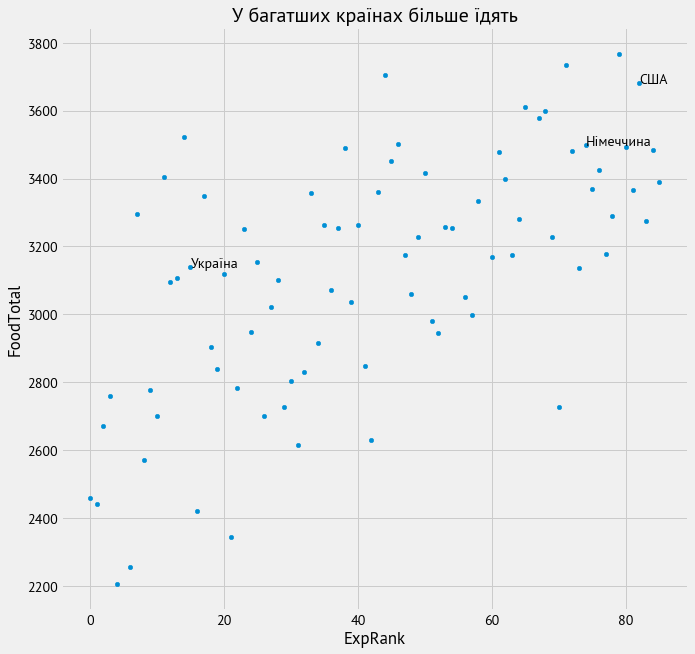

In [34]:
ax = energy_dist_data.plot.scatter(
    'ExpRank', 'FoodTotal', figsize=(10, 10), title='У багатших країнах більше їдять'
)

for func in [annotate_ua, annotate_de, annotate_us]:
    func(df=energy_dist_data, ax=ax, x_col='ExpRank', y_col='FoodTotal', x_offset=0, y_offset=0)

У багатих країнах їдять більше тваринної їжі.

In [35]:
vegetal = 'Vegetal Products'
animal = 'Animal Products'

In [36]:
vegetal_vs_plant = (faostat_data[
    (faostat_data['Flag'] == 'Fc') &
    (faostat_data['Item'].isin([vegetal, animal])) &
    (faostat_data['Element'] == TOTAL_KCAL_NAME)
][['Country', 'Item', 'Value']]
.pivot(index='Country', columns='Item', values='Value')
.assign(AnimalFraction=lambda x: x['Animal Products'] / (x.sum(axis=1))))

In [37]:
vegetal_vs_plant.head()

Item,Animal Products,Vegetal Products,AnimalFraction
Country,,,
Afghanistan,216.0,1873.0,0.103399
Albania,987.0,2206.0,0.309114
Algeria,379.0,2917.0,0.114988
Angola,254.0,2219.0,0.102709
Antigua and Barbuda,780.0,1637.0,0.322714


In [38]:
def plot_faostat_item_vs_wealth(df, x_col, y_col, title=''):
    ax = df.plot.scatter(
        x=x_col, y=y_col, title=title, figsize=(10, 10)
    )
    for func in (annotate_ua, annotate_us, annotate_de):
        # def annotate(country, label, df, x_col, y_col, ax, x_offset=-.6, y_offset=1000):
        func(df=df, x_col=x_col, y_col=y_col, ax=ax, x_offset=0, y_offset=0)
    return ax

In [39]:
def faostat_value_vs_expend_rating(faostat_slice, expend_data, 
                                   dependent_col='Value', independent_col='ExpRating', title=''):
    merged_data = pd.merge(
        faostat_slice, expend_data, left_index=True, right_index=True
    )
    
    # calculate regression model
    model = OLS(merged_data[dependent_col], add_constant(merged_data[independent_col]), missing='drop').fit()
    print(model.summary())
    
    # find values furthers from the regression line
    sorted_resid = model.resid.sort_values()
    
    ax = plot_faostat_item_vs_wealth(merged_data, independent_col, dependent_col, title)
    min_max_n = [merged_data[independent_col].min(), merged_data[independent_col].max()]
    plt.plot(min_max_n, model.predict(add_constant(min_max_n)), c='red', linewidth=.5)

    for country in sorted_resid[:5].index:
        annotate(country, country, merged_data, independent_col, dependent_col, ax, 1, 0)

    for country in sorted_resid[-5:].index:
        annotate(country, country, merged_data, independent_col, dependent_col, ax, 1, 0)
    return ax

                            OLS Regression Results                            
Dep. Variable:         AnimalFraction   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     106.7
Date:                Tue, 22 Aug 2017   Prob (F-statistic):           2.21e-16
Time:                        22:36:50   Log-Likelihood:                 125.58
No. Observations:                  82   AIC:                            -247.2
Df Residuals:                      80   BIC:                            -242.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1209      0.012     10.465      0.0

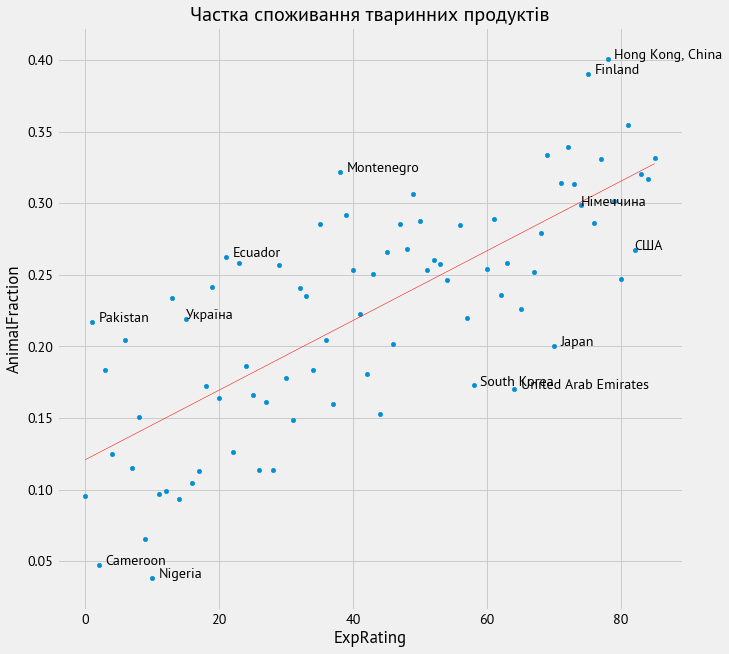

In [40]:
faostat_value_vs_expend_rating(
    vegetal_vs_plant, ers_data, 'AnimalFraction', title='Частка споживання тваринних продуктів'
)

## Розподіл калорій між білками, жирами і вуглеводами

FAOSTAT має агреговані дані по білках і жирах, тому вуглеводи треба розрахувати окремо.

In [41]:
ALCOHOL_ITEM_NAME = 'Alcoholic Beverages'
alcohol_data = select_faostat_item_total(faostat_data, ALCOHOL_ITEM_NAME, 'Alcohol')

In [42]:
# calories that don't come from fats, protein or alcohol must come from carbs
energy_dist_data = energy_dist_data.assign(
    Carbs=lambda df: df['FoodTotal'] - df[['Protein', 'Fat']].sum(axis=1) - alcohol_data.loc[df.index].Alcohol
)
energy_dist_data.head()

,ExpRank,Fat,FoodExp,FoodTotal,Protein,TotalExp,Carbs
Algeria,7.0,673.640,792.0,3296.0,367.84,1858.7,2247.520
Argentina,49.0,1024.848,1991.5,3229.0,410.56,9630.7,1688.592
Australia,83.0,1327.480,3582.6,3276.0,425.12,36004.2,1387.400
Austria,79.0,1499.872,2730.3,3768.0,424.84,27383.9,1600.288
Azerbaijan,20.0,521.576,1345.4,3118.0,372.60,3244.7,2069.824


In [43]:
# add avg "healthy" amount
# recommended energy intake https://en.wikipedia.org/wiki/Food_energy#Recommended_daily_intake
female_kcal = 2000
male_kcal = 2600
avg_kcal = (female_kcal + male_kcal) / 2

# healthy proportions from https://www.nap.edu/read/10490/chapter/32#1325
carb_range = (avg_kcal * 0.45, avg_kcal * 0.65)
fat_range = (avg_kcal * 0.20, avg_kcal * 0.35)
prot_range = (avg_kcal * 0.10, avg_kcal * 0.35)

In [44]:
def plot_recommended_intake(x_range, y_range, color, ax):
    linewidth = 1.5
    ax.fill_between(x_range, [y_range[0]]*2, [y_range[1]]*2, color='white')
    # for lim in y_range:
    #     ax.plot(x_range, [lim]*2, c=color, linewidth=linewidth)

In [45]:
def plot_energy_sources(df, x_col='ExpRank', save_path=None):
    fig, axs = plt.subplots(1, 3, figsize=(15, 6))

    x_min = df[x_col].min()
    x_max = df[x_col].max()
    x_range = (x_min, x_max + (x_max - x_min) / 40)

    carb_color = colors['blue']
    fat_color = colors['purple']
    prot_color = colors['red']

    for (i, (y_col, color, rec_range, label)) in enumerate((
        ('Protein', prot_color, prot_range, 'Білки'),
        ('Fat', fat_color, fat_range, 'Жири'),
        ('Carbs', carb_color, carb_range, 'Вуглеводи'), 
    )):
        plot_recommended_intake(x_range, rec_range, color, axs[i])
        axs[i].scatter(
            df[x_col], df[y_col], c=color, s=18, label=label
        )
        axs[i].set_title(label, fontsize=16,)
        for func in [annotate_ua, annotate_de, annotate_us]:
            func(df=df, ax=axs[i], x_col=x_col, y_col=y_col, x_offset=0, y_offset=0)


    axis_label_fontsize = 14
    # axs[2].set_xlabel('Місце країни в рейтингу — від найбідніших до найбагатших', 
    #              labelpad=20, fontsize=axis_label_fontsize)
    for ax in axs:
        ax.get_xaxis().set_ticks([])
        ax.grid(b=False)
        ax.set_ylim(200, 2700)

    for ax in axs[1:]:
        ax.get_yaxis().set_ticks([])

    axs[0].set_ylabel(
        'ккал/людина/день', labelpad=20,
        fontsize=axis_label_fontsize
    )

    fig.suptitle('Заможніші країни їдять більше жирів і білків, але менше вуглеводів', fontsize=20)
    plt.subplots_adjust(top=.85, bottom=.1, wspace=.0)

    if save_path:
        plt.savefig(save_path)

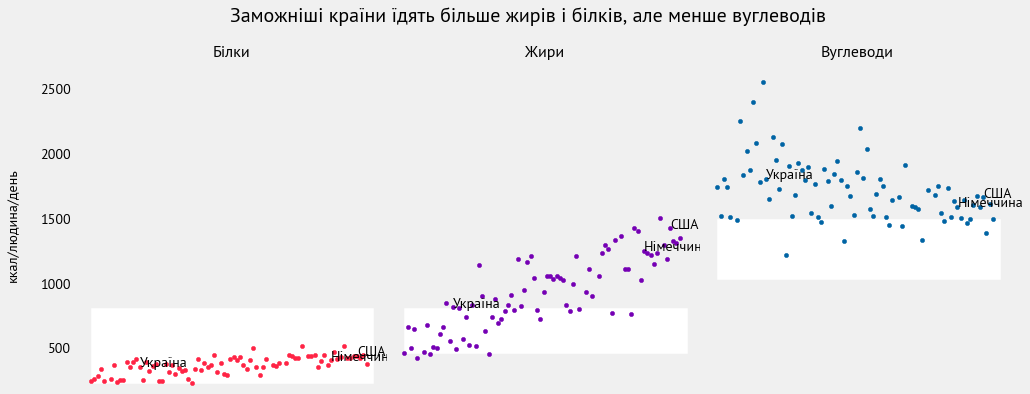

In [46]:
plot_energy_sources(energy_dist_data)

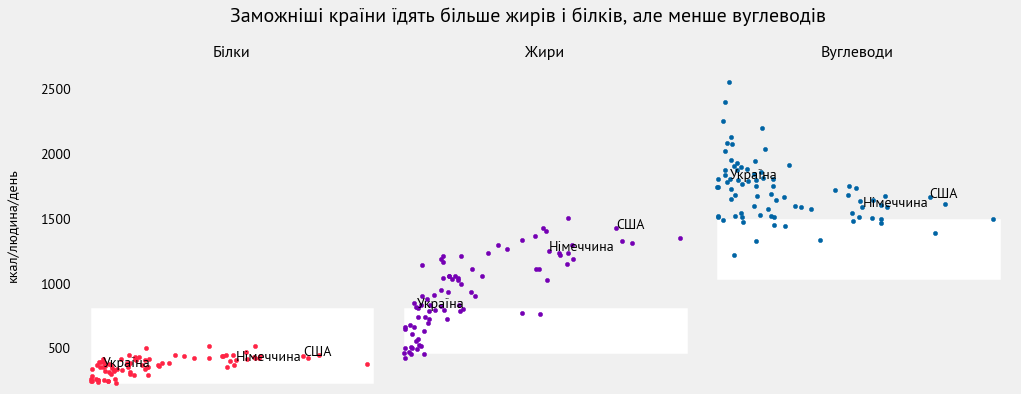

In [47]:
# plot with absolute values of total expense
# most of the dots cluster on the left half of the plot and it doesn't look nice
plot_energy_sources(energy_dist_data, 'TotalExp')

In [48]:
energy_dist_data['TotalExpLog2'] = np.log2(energy_dist_data.TotalExp)

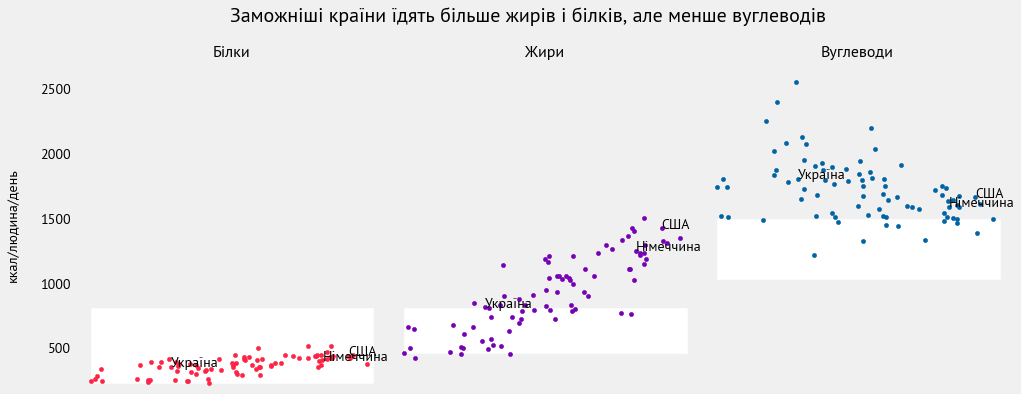

In [49]:
# log axis looks similar ot rank axis but it's harder to explain
plot_energy_sources(energy_dist_data, 'TotalExpLog2')

In [50]:
energy_dist_data.loc['United States']

ExpRank            82.000000
Fat              1421.552000
FoodExp          2347.200000
FoodTotal        3682.000000
Protein           438.400000
TotalExp        35160.600000
Carbs            1663.048000
TotalExpLog2       15.101672
Name: United States, dtype: float64

In [51]:
energy_dist_data.loc['Ukraine']

ExpRank           15.0000
Fat              814.9680
FoodExp         1090.1000
FoodTotal       3138.0000
Protein          354.4800
TotalExp        2893.7000
Carbs           1806.5520
TotalExpLog2      11.4987
Name: Ukraine, dtype: float64

In [52]:
energy_dist_data.loc['Germany']

ExpRank            74.000000
Fat              1248.456000
FoodExp          2477.200000
FoodTotal        3499.000000
Protein           406.360000
TotalExp        24329.300000
Carbs            1589.184000
TotalExpLog2       14.570407
Name: Germany, dtype: float64

## Забезпечення головними групами їжі

Спершу слід розрахувати розміри порцій і бажані кількості для кожної групи. Рекомендації різні для різних статей і вікових груп, що знайти приблизне середнє значення, я використовую зважене середнє з урахуванням демографічної структури популяції України у 2013.

In [53]:
# https://www.eatforhealth.gov.au/food-essentials/how-much-do-we-need-each-day/serve-sizes
J_to_cal = 0.000239006 * 1000
serving_sizes_kJ = {
    'vegetables': (100, 350),
    'fruits': (350),
    'grains': (500),
    'protein': (500, 600),
    'milk': (500, 600),
    # sugar 31 kcal (8g) allowed - 3
    # alcohol 125 kcal - allowed 2 
    # fat 120 kcal
}

In [54]:
# http://database.ukrcensus.gov.ua/Mult/Dialog/varval.asp?ma=000_0204&ti=0204.%20%D0%A0%D0%BE%D0%B7%D0%BF%D0%BE%D0%B4%D1%96%D0%BB%20%D0%BF%D0%BE%D1%81%D1%82%D1%96%D0%B9%D0%BD%D0%BE%D0%B3%D0%BE%20%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%BD%D1%8F%20%D0%B7%D0%B0%20%D1%81%D1%82%D0%B0%D1%82%D1%82%D1%8E,%20%D0%B2%D1%96%D0%BA%D0%BE%D0%B2%D0%B8%D0%BC%D0%B8%20%D0%B3%D1%80%D1%83%D0%BF%D0%B0%D0%BC%D0%B8%20%D1%82%D0%B0%20%D1%82%D0%B8%D0%BF%D0%BE%D0%BC%20%D0%BF%D0%BE%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D1%8C%20(0,1)&path=../Database/Population/02/02/&lang=1&multilang=uk
ua_demographic_structure = pd.read_csv('./data/ua_demographic_structure.csv', sep='\t')

In [55]:
# https://www.eatforhealth.gov.au/food-essentials/how-much-do-we-need-each-day/recommended-number-serves-adults
recommended_servings = pd.read_csv('./data/recommended_servings.csv', sep='\t')

In [56]:
recommended_servings

,Unnamed: 0,vegetables,fruits,grains,protein,milk
0,Men 19-50,6.0,2,6.0,3.0,2.5
1,Men 51-70,5.5,2,6.0,2.5,2.5
2,Men 70+,5.0,2,4.5,2.5,3.5
3,Women 19-50,5.0,2,6.0,2.5,2.5
4,Women 51-70,5.0,2,4.0,2.0,4.0
5,Women 70+,5.0,2,3.0,2.0,4.0


In [57]:
# select population groups and count % from total
tot_pop = ua_demographic_structure[['Male', 'Female']][19:].sum().sum()
age_slices = (slice(19, 51), slice(51, 71), slice(71, None))
sexes = ('Male', 'Female')
ua_pop_percentage = []
for sex, age in product(sexes, age_slices):
    ua_pop_percentage.append(ua_demographic_structure[age][sex].sum() / tot_pop)

In [58]:
# make sure that all adult groups sum up to 1
np.sum(ua_pop_percentage)

1.0

In [59]:
recommended_servings['ua_pop_percentage'] = ua_pop_percentage
recommended_servings

,Unnamed: 0,vegetables,fruits,grains,protein,milk,ua_pop_percentage
0,Men 19-50,6.0,2,6.0,3.0,2.5,0.285603
1,Men 51-70,5.5,2,6.0,2.5,2.5,0.122938
2,Men 70+,5.0,2,4.5,2.5,3.5,0.041489
3,Women 19-50,5.0,2,6.0,2.5,2.5,0.290952
4,Women 51-70,5.0,2,4.0,2.0,4.0,0.167377
5,Women 70+,5.0,2,3.0,2.0,4.0,0.091641


In [60]:
recommended_servings_num = (recommended_servings[['vegetables', 'fruits', 'grains', 'protein', 'milk']]
 .multiply(recommended_servings['ua_pop_percentage'], axis=0)
 .sum(axis=0).round().astype(int))

In [61]:
guidelines = {}
for f in sorted(serving_sizes_kJ):
    guidelines[f] = [np.mean(serving_sizes_kJ[f]) * J_to_cal, recommended_servings_num[f]]
guidelines = pd.DataFrame(guidelines, index=['kcal_per_serving', 'num_servings'])

In [62]:
# загальна сума виходить більш-менш нормальна, решту можна наїсти будь-чим, мабуть
# для жінок виходить якраз +2 порції (~100 kcal) - 2000 kcal, для чоловіків трохи не дотягує, але хай поки так
(guidelines.loc['kcal_per_serving'] * guidelines.loc['num_servings']).sum()

1822.4207499999998

In [63]:
guidelines.loc['recommended_kcal'] = guidelines.loc['kcal_per_serving'] * guidelines.loc['num_servings']

In [64]:
guidelines

,fruits,grains,milk,protein,vegetables
kcal_per_serving,83.6521,119.503,131.4533,131.4533,53.77635
num_servings,2.0000,5.000,3.0000,3.0000,5.00000
recommended_kcal,167.3042,597.515,394.3599,394.3599,268.88175


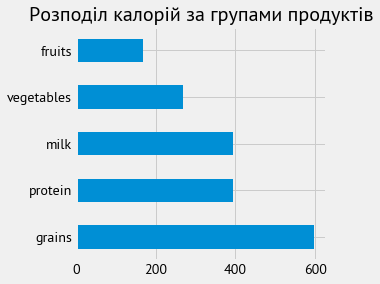

In [65]:
(guidelines.loc['recommended_kcal'].sort_values(ascending=False)
 .plot.barh(figsize=(4, 4), title='Розподіл калорій за групами продуктів'))

In [66]:
groups = {
    'alcohol': ['Alcoholic Beverages', ],
    'sugar': ['Sugar & Sweeteners'],
    'fats': ['Animal fats', 'Vegetable Oils'], 
    'vegetables': ['Starchy Roots', 'Vegetables'],
    'grains': ['Cereals - Excluding Beer', ],
    'protein': ['Eggs', 'Fish, Seafood', 'Meat', 'Offals', 'Pulses', 'Treenuts'],
    'milk': ['Milk - Excluding Butter', ],
    'fruits': ['Fruits - Excluding Wine', ],
}

In [67]:
# some items are duplicated - aggregated and 'normal' names are the same, so I need to exclude the following
# 'normal' items
exclude_dup_items = [2744, 2848, 2899]

In [68]:
food_groups = (faostat_data[
    faostat_data.Item.isin(chain(*groups.values())) &
    (~faostat_data['Item Code'].isin(exclude_dup_items)) &
    (faostat_data.Element == 'Food supply (kcal/capita/day)')
][['Country', 'Item', 'Value']]
 .pivot(columns='Country', index='Item', values='Value'))

In [69]:
food_groups.head()

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Republic of Tanzania,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Viet Nam,Yemen,Zambia,Zimbabwe
Item,,,,,,,,,,,,,,,,,,,,,
Alcoholic Beverages,0.0,73.0,7.0,115.0,84.0,105.0,13.0,136.0,243.0,154.0,...,62.0,159.0,84.0,38.0,15.0,91.0,39.0,1.0,32.0,76.0
Animal fats,38.0,52.0,17.0,12.0,75.0,57.0,113.0,138.0,392.0,66.0,...,19.0,101.0,65.0,39.0,41.0,30.0,48.0,16.0,7.0,28.0
Cereals - Excluding Beer,1561.0,1145.0,1678.0,717.0,653.0,1060.0,1075.0,740.0,886.0,1794.0,...,943.0,801.0,1087.0,1419.0,808.0,970.0,1552.0,1356.0,1135.0,1146.0
Eggs,5.0,46.0,27.0,4.0,15.0,41.0,45.0,32.0,57.0,31.0,...,2.0,56.0,47.0,20.0,13.0,20.0,15.0,9.0,11.0,6.0
"Fish, Seafood",0.0,9.0,8.0,25.0,79.0,13.0,9.0,41.0,32.0,5.0,...,13.0,35.0,15.0,2.0,72.0,22.0,52.0,5.0,11.0,6.0


In [70]:
main_food_groups = pd.DataFrame({
    group: food_groups.loc[subgroups].sum(axis=0) for group, subgroups in groups.items()
})

In [71]:
main_food_groups.head()

,alcohol,fats,fruits,grains,milk,protein,sugar,vegetables
Country,,,,,,,,
Afghanistan,0.0,128.0,51.0,1561.0,100.0,113.0,87.0,32.0
Albania,73.0,223.0,221.0,1145.0,533.0,479.0,197.0,229.0
Algeria,7.0,377.0,215.0,1678.0,227.0,226.0,265.0,250.0
Angola,115.0,228.0,128.0,717.0,20.0,303.0,146.0,767.0
Antigua and Barbuda,84.0,292.0,168.0,653.0,224.0,514.0,302.0,105.0


In [72]:
main_food_groups_servings = (main_food_groups / guidelines.loc['kcal_per_serving']).round().dropna(axis=1)

In [73]:
for col in main_food_groups_servings:
    main_food_groups_servings[col] = main_food_groups_servings[col].astype(int)

In [74]:
main_food_groups_servings.head()

,fruits,grains,milk,protein,vegetables
Country,,,,,
Afghanistan,1,13,1,1,1
Albania,3,10,4,4,4
Algeria,3,14,2,2,5
Angola,2,6,0,2,14
Antigua and Barbuda,2,5,2,4,2


In [75]:
main_food_groups_servings.loc['Ukraine']

fruits        1
grains        9
milk          2
protein       3
vegetables    7
Name: Ukraine, dtype: int64

In [76]:
food_groups_colors = {
    'fruits': "#7500B4", 
    'grains': '#0064A4',
    'milk': '#FFA103',
    'protein': '#FF2445',
    'vegetables': '#56BA00',
}

In [77]:
groups_order = ['grains', 'vegetables', 'milk', 'protein', 'fruits']

def draw_a_square(x, y, color, ax, height=1, filled=False):
    offset = .05
    xs = [(x + 0.5 + offset), (x + 1.5 - offset)]
    bottom = [(y + offset)] * 2
    top = [(y + 1 - offset)] * 2
    patch = matplotlib.patches.Rectangle(
        (x + 0.5 + offset, y + offset),
        width=1 - offset*2,
        height=(1 - offset*2) * height,
        facecolor=color,
        fill=filled,
        edgecolor=color,
        linewidth=2 if not filled else 0,
        alpha=1 if not filled else .7,
    )
    ax.add_patch(patch)


def draw_guidlines(guidlines_df, ax):
    for x, col in enumerate(groups_order):
        for y in range(int(guidlines_df[col].num_servings)):
            draw_a_square(x, y, food_groups_colors[col], ax)
    
    # additional portions
    # additional_portions = 2
    # for y in range(additional_portions):
    #    draw_a_square(len(guidlines_df.columns) + 0.5, y, '#333333', ax)


def draw_country_portions(country, guidlines_df, ax):
    remains = {}
    recommended_servings = guidlines_df.loc['num_servings']
    
    # draw recommended portions
    for x, group in enumerate(groups_order):
        remains[group] = max(country[group] - recommended_servings[group], 0)
        for y in range(min(country[group], int(recommended_servings[group]))):
            draw_a_square(x, y, food_groups_colors[group], ax, filled=True)
    
    # draw extra portions
    x = len(groups_order) + .5
    y = 0
    for group in groups_order:
        for _ in range(int(remains[group])):
            draw_a_square(x, y, food_groups_colors[group], ax, filled=True)
            y += 1

def draw_country_calories_from_main_food(country_calory_dist, country_energy_dist, ax):
    # calculate this hardcoded value
    y = 7
    x = 7
    height = .4
    main_group = country_calory_dist[groups_order].sum()
    total = country_energy_dist.FoodTotal
    print(total, main_group, total - main_group)
    percent = main_group / total
    all_cal_patch = matplotlib.patches.Rectangle(
        (0.5, y - .5), width=x - 0.5, height=height, fill=False, linewidth=1, color='gray'
    )
    main_cal_length = (x - 0.5) * percent
    main_cal_patch = matplotlib.patches.Rectangle(
        (0.5, y - .5), width=main_cal_length, height=height, linewidth=1, color='gray', alpha=.5
    )
    ax.add_patch(all_cal_patch)
    ax.add_patch(main_cal_patch)
    ax.annotate('{0:.1f}%'.format(percent * 100), (main_cal_length - .6, y - .43), color='white')

In [78]:
def plot_country_food_groups(country, title, ax):
    draw_guidlines(guidelines, ax)
    draw_country_portions(main_food_groups_servings.loc[country], guidelines, ax)
    draw_country_calories_from_main_food(main_food_groups.loc[country], energy_dist_data.loc[country], ax)

    ax.set_xlim(0, 7.5)
    ax.set_ylim(0, 7.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    #ax.set_facecolor('white')
    ax.grid(b=False)

3138.0 2114.0 1024.0
3499.0 1989.0 1510.0
3682.0 2038.0 1644.0


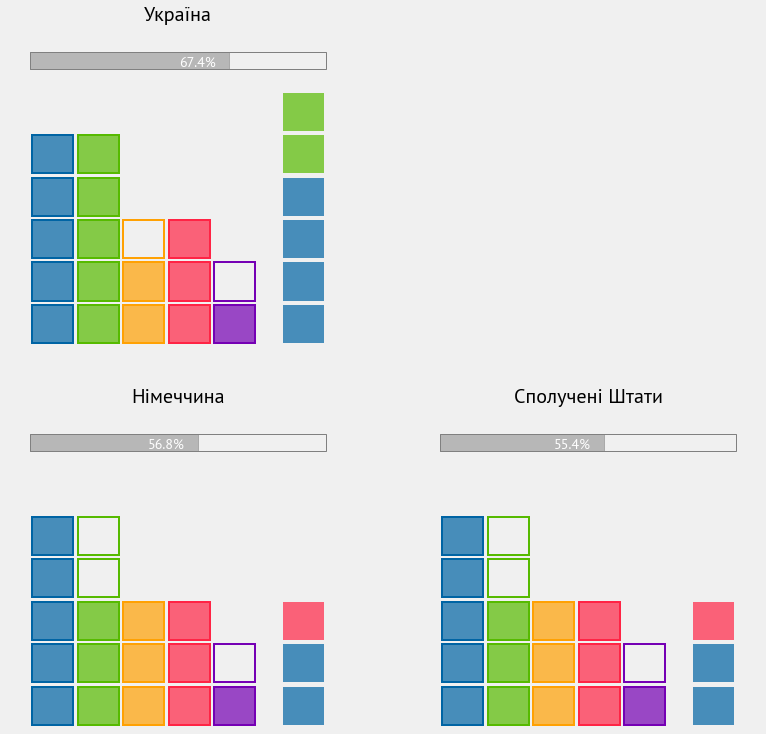

In [79]:
fig = plt.figure(figsize=(12, 12))
plot_country_food_groups('Ukraine', 'Україна', fig.add_subplot(2, 2, 1))
plot_country_food_groups('Germany', 'Німеччина', fig.add_subplot(2, 2, 3))
plot_country_food_groups('United States', 'Сполучені Штати', fig.add_subplot(2, 2, 4))
# plt.savefig('./imgs/food_groups.svg')

In [80]:
foods_kcal = (faostat_data[
    (~faostat_data.Item.isin(chain(
        ['Grand Total', 'Vegetal Products', 'Animal Products', 'Miscellaneous'], *groups.values()
    )) | 
     (faostat_data['Item Code'].isin(exclude_dup_items))) &
    (faostat_data.Element == 'Food supply (kcal/capita/day)')
][['Country', 'Item', 'Value']]
.pivot(columns='Country', index='Item', values='Value')
.fillna(0)
)

In [81]:
faostat_data[
    (faostat_data.Item.isin([
        'Oilcrops', 'Sugar Crops', 'Stimulants', 'Spices'
    ])) &
    (faostat_data.Element == 'Food supply (kcal/capita/day)') &
    (faostat_data.Country.isin(['Ukraine', 'Germany', 'United States']))
][['Country', 'Item', 'Value']].pivot(index='Country', columns='Item', values='Value').sum(axis=1)

Country
Germany          68.0
Ukraine          23.0
United States    95.0
dtype: float64

Світліший колір для картоплі додам вручну в Inkscape

In [82]:
foods_kcal['Ukraine']['Potatoes and products'] / guidelines.vegetables['kcal_per_serving']

4.6302882214951371

In [83]:
foods_kcal['Germany']['Potatoes and products'] / guidelines.vegetables['kcal_per_serving']

2.138486527999762

In [84]:
foods_kcal['United States']['Potatoes and products'] / guidelines.vegetables['kcal_per_serving']

1.5620249421911305

Слід порівняти дані FAOSTAT із Держстатом, пересвідчитися, що вони хоча б одного порядку

In [85]:
foods_quant = (faostat_data[
    (~faostat_data['Item Code'].isin(exclude_dup_items)) &
    (faostat_data.Element == 'Food supply quantity (kg/capita/yr)')
][['Country', 'Item', 'Value']]
.pivot(columns='Country', index='Item', values='Value')
.fillna(0)
)

In [86]:
foods_quant['Ukraine'][['Potatoes and products', 'Vegetables', 'Meat', 'Fish, Seafood', 'Milk - Excluding Butter']]

Item
Potatoes and products      135.94
Vegetables                 163.78
Meat                        54.75
Fish, Seafood               17.03
Milk - Excluding Butter    145.03
Name: Ukraine, dtype: float64

In [87]:
# comparison wiht Ukrainian derzhstat data, kg/month
print('Картошечка: держстат: 7.1, faostat: {}'.format(136 / 12))
print('Овочі: держстат: 9.4, faostat: {:.2f}'.format(164 / 12))
print('Мʼясо: держстат: 5.1, faostat: {:.2f}'.format(55 / 12))
print('Риба: держстат: 1.8, faostat: {:.2f}'.format(17 / 12))
print('Молоко: держстат: 20.3, faostat: {:.2f}'.format(145 / 12))

Картошечка: держстат: 7.1, faostat: 11.333333333333334
Овочі: держстат: 9.4, faostat: 13.67
Мʼясо: держстат: 5.1, faostat: 4.58
Риба: держстат: 1.8, faostat: 1.42
Молоко: держстат: 20.3, faostat: 12.08


## Багатство й індекс маси тіла

In [88]:
who_data_2013 = who_data[[' 2013']]
who_data_2013.columns = ['Male', 'Female']

In [89]:
who_data_2013.head()

,Male,Female
Afghanistan,21.5,23.5
Albania,26.5,25.7
Algeria,24.2,25.9
Andorra,27.6,26.6
Angola,22.7,24.0


In [90]:
bmi_and_expend_data = pd.merge(who_data_2013, ers_data, left_index=True, right_index=True)

[]

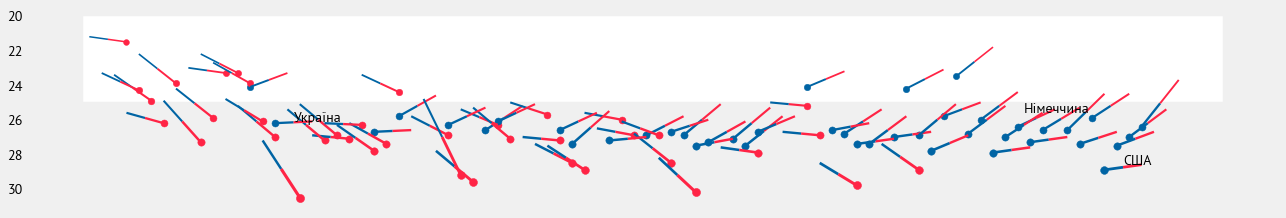

In [91]:
fig = plt.figure(figsize=(20, 3.5))

plt.fill_between([-2, 90], [20, 20], [24.9, 24.9], color='white')

for row in bmi_and_expend_data.iterrows():
    male = row[1].Male
    female = row[1].Female
    avg = (male + female) / 2
    rank = row[1].ExpRating
    line_len = 1.5
    plt.plot([rank - line_len, rank], [male, avg], linewidth=male ** 2 / 300, c=colors['blue'])
    plt.plot([rank, rank + line_len], [avg, female], linewidth=female ** 2 / 300, c=colors['red'])
    if male > female:
        plt.scatter([rank - line_len], [male], c=colors['blue'], s=male**2 / 14)
    else:
        plt.scatter([rank + line_len], [female], c=colors['red'], s=female**2 / 14)


for func in [annotate_ua, annotate_de, annotate_us]:
    func(df=bmi_and_expend_data, ax=fig.axes[0], x_col='ExpRating', y_col='Female', x_offset=0, y_offset=0)

plt.gca().invert_yaxis()
fig.axes[0].grid(b=False)
fig.axes[0].set_xticks([])

# plt.savefig('./imgs/bmi.svg')

In [92]:
bmi_and_expend_data[bmi_and_expend_data.Male < 25].sort_values('ExpRating')

,Male,Female,TotalExp,FoodExp,ExpRating
India,21.2,21.5,933.2,284.9,0
Pakistan,23.3,24.3,983.2,419.5,1
Cameroon,23.4,24.9,1010.0,462.1,2
Kenya,22.2,23.9,1081.9,507.5,4
Bolivia,24.9,27.3,1772.6,508.0,6
Algeria,24.2,25.9,1858.7,792.0,7
Philippines,23.0,23.3,2068.3,877.9,8
Indonesia,22.2,23.3,2069.6,687.1,9
Nigeria,22.7,23.9,2130.0,1208.2,10
Morocco,24.8,26.1,2159.3,773.8,11


In [93]:
bmi_and_expend_data[
    (bmi_and_expend_data.Male > 25) & (bmi_and_expend_data.Female < 25)
].sort_values('ExpRating')

,Male,Female,TotalExp,FoodExp,ExpRating
Bosnia and Herzegovina,25.8,24.6,4075.1,1274.6,25
France,26.0,24.4,23836.8,3190.0,72
Austria,26.6,24.5,27383.9,2730.3,79
Denmark,25.9,24.5,28228.0,3234.9,81
Switzerland,26.4,23.7,45386.5,4072.4,85


In [94]:
bmi_and_expend_data.loc['Ukraine']

Male           26.2
Female         26.1
TotalExp     2893.7
FoodExp      1090.1
ExpRating      15.0
Name: Ukraine, dtype: float64

In [95]:
bmi_and_expend_data.loc['Germany']

Male            27.0
Female          25.6
TotalExp     24329.3
FoodExp       2477.2
ExpRating       74.0
Name: Germany, dtype: float64

In [96]:
bmi_and_expend_data.loc['United States']

Male            28.9
Female          28.6
TotalExp     35160.6
FoodExp       2347.2
ExpRating       82.0
Name: United States, dtype: float64